In [141]:
# -*- coding: utf-8 -*-
# Authors: Chitta Ranjan <cran2367@gmail.com>
#
# License: BSD 3 clause

In [131]:
import numpy as np
import pandas as pd
from itertools import chain
import warnings

########
from sklearn.preprocessing import LabelEncoder
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
np.random.seed(7) # fix random seed for reproducibility
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import sklearn.metrics
import time

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

from sgt import Sgt

## Test Examples

In [3]:
sgt = Sgt()

In [4]:
sequence = np.array(["B","B","A","C","A","C","A","A","B","A"])
alphabets = np.array(["A", "B", "C"])
lengthsensitive = True
kappa = 5

In [6]:
sgt.getpositions(sequence = sequence, alphabets = alphabets)

[('A', (array([2, 4, 6, 7, 9]),)),
 ('B', (array([0, 1, 8]),)),
 ('C', (array([3, 5]),))]

In [7]:
sgt.fit(sequence, alphabets, lengthsensitive, kappa, flatten=False)

,A,B,C
A,0.369361,0.442463,0.537637
B,0.414884,0.468038,0.162774
C,0.454136,0.068693,0.214492


In [8]:
corpus = [["B","B","A","C","A","C","A","A","B","A"], ["C", "Z", "Z", "Z", "D"]]

In [9]:
s = sgt.fit_transform(corpus)
print(s)

[[0.90616284 1.31002279 2.6184865  0.         0.         0.86569371
  1.23042262 0.52543984 0.         0.         1.37141609 0.28262508
  1.35335283 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.09157819 0.92166965 0.         0.         0.
  0.         0.         0.         0.         0.         0.92166965
  1.45182361 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]]


## Protein Sequence Data Analysis

The data used here is taken from www.uniprot.org. This is a public database for proteins. The data contains the protein sequences and their functions. In the following, we will demonstrate 
- clustering of the sequences.
- classification of the sequences with the functions as labels.

In [212]:
protein_data=pd.DataFrame.from_csv('../data/protein_classification.csv')
X=protein_data['Sequence']
def split(word): 
    return [char for char in word] 

sequences = [split(x) for x in X]
print(sequences[0])

['M', 'E', 'I', 'E', 'K', 'T', 'N', 'R', 'M', 'N', 'A', 'L', 'F', 'E', 'F', 'Y', 'A', 'A', 'L', 'L', 'T', 'D', 'K', 'Q', 'M', 'N', 'Y', 'I', 'E', 'L', 'Y', 'Y', 'A', 'D', 'D', 'Y', 'S', 'L', 'A', 'E', 'I', 'A', 'E', 'E', 'F', 'G', 'V', 'S', 'R', 'Q', 'A', 'V', 'Y', 'D', 'N', 'I', 'K', 'R', 'T', 'E', 'K', 'I', 'L', 'E', 'D', 'Y', 'E', 'M', 'K', 'L', 'H', 'M', 'Y', 'S', 'D', 'Y', 'I', 'V', 'R', 'S', 'Q', 'I', 'F', 'D', 'Q', 'I', 'L', 'E', 'R', 'Y', 'P', 'K', 'D', 'D', 'F', 'L', 'Q', 'E', 'Q', 'I', 'E', 'I', 'L', 'T', 'S', 'I', 'D', 'N', 'R', 'E']


### Generating sequence embeddings

In [222]:
sgt = Sgt(kappa = 1, lengthsensitive = False)

In [223]:
embedding = sgt.fit_transform(corpus=sequences)

In [224]:
embedding.shape

(2112, 400)

#### Sequence Clustering
We perform PCA on the sequence embeddings and then do kmeans clustering.

In [16]:
pca = PCA(n_components=2)
pca.fit(embedding)
X=pca.transform(embedding)

print(np.sum(pca.explained_variance_ratio_))
df = pd.DataFrame(data=X, columns=['x1', 'x2'])
df.head()

0.6019403543806409


,x1,x2
0,-1.120859,1.046758
1,-0.655127,-0.211338
2,0.034157,0.312279
3,0.502963,0.015795
4,-1.128862,1.034211


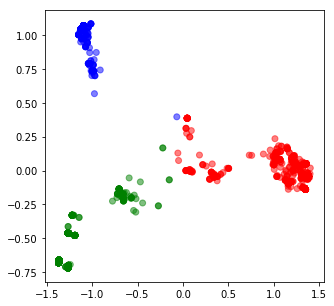

In [205]:
kmeans = KMeans(n_clusters=3, max_iter =300)
kmeans.fit(df)

labels = kmeans.predict(df)
centroids = kmeans.cluster_centers_

fig = plt.figure(figsize=(5, 5))
colmap = {1: 'r', 2: 'g', 3: 'b'}
colors = list(map(lambda x: colmap[x+1], labels))
plt.scatter(df['x1'], df['x2'], color=colors, alpha=0.5, edgecolor=colors)

#### Sequence Classification
We perform PCA on the sequence embeddings and then do kmeans clustering.

In [225]:
y = protein_data['Function [CC]']
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

We will perform a 10-fold cross-validation to measure the performance of the classification model.

In [226]:
kfold = 10
X = pd.DataFrame(embedding)
y = encoded_y

random_state = 1

test_F1 = np.zeros(kfold)
skf = KFold(n_splits = kfold, shuffle = True, random_state = random_state)
k = 0
epochs = 50
batch_size = 128

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = X_train.as_matrix(columns = None)
    X_test = X_test.as_matrix(columns = None)
    
    model = Sequential()
    model.add(Dense(64, input_shape = (X_train.shape[1],), init = 'uniform')) 
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, init='uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.fit(X_train, y_train ,batch_size=batch_size, epochs=epochs, verbose=0)
    
    y_pred = model.predict_proba(X_test).round().astype(int)
    y_train_pred = model.predict_proba(X_train).round().astype(int)

    test_F1[k] = sklearn.metrics.f1_score(y_test, y_pred)
    k+=1
    
print ('Average f1 score', np.mean(test_F1))

/Users/inferno/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, input_shape=(400,), kernel_initializer="uniform")`
/Users/inferno/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, kernel_initializer="uniform")`
/Users/inferno/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform")`


Average test accuracy 1.0


## Weblog Data Analysis
This data sample is taken from https://www.ll.mit.edu/r-d/datasets/1998-darpa-intrusion-detection-evaluation-dataset. 
This is a network intrusion data containing audit logs and any attack as a positive label. Since, network intrusion is a rare event, the data is unbalanced. Here we will,
- build a sequence classification model to predict a network intrusion.

Each sequence contains in the data is a series of activity, for example, {login, password}. The _alphabets_ in the input data sequences are already encoded into integers. The original sequences data file is also present in the `/data` directory.

In [153]:
darpa_data = pd.DataFrame.from_csv('../data/darpa_data.csv')
darpa_data.columns

Index(['seqlen', 'seq', 'class'], dtype='object')

In [154]:
X = darpa_data['seq']
sequences = [x.split('~') for x in X]

In [155]:
y = darpa_data['class']
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

### Generating sequence embeddings
In this data, the sequence embeddings should be length-sensitive. The lengths are important here because sequences with similar patterns but different lengths can have different labels. Consider a simple example of two sessions: `{login, pswd, login, pswd,...}` and `{login, pswd,...(repeated several times)..., login, pswd}`. While the first session can be a regular user mistyping the password once, the other session is possibly an attack to guess the password. Thus, the sequence lengths are as important as the patterns.

In [186]:
sgt_darpa = Sgt(kappa = 5, lengthsensitive = True)

In [187]:
embedding = sgt_darpa.fit_transform(corpus=sequences)

In [188]:
pd.DataFrame(embedding).to_csv(path_or_buf='tmp.csv', index=False)
pd.DataFrame(embedding).head()

,0,1,2,3,4,5,6,7,8,9,...,2391,2392,2393,2394,2395,2396,2397,2398,2399,2400
0,0.069114,0.594892,1.531443e-01,5.846226e-01,2.180165e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,4.804190e-09,7.041516e-10,0.000000e+00,2.004958e-12,1.316455e-04,1.046458e-07,5.863092e-16,7.568986e-23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.423141,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.785666,0.000000,0.000000e+00,0.000000e+00,1.950089e-03,2.239981e-04,2.343180e-07,4.388479e-03,3.606850e-03,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.173488,4.260410e-03,0.000000e+00,4.966394e-16,5.337432e-01,1.746567e-13,1.667217e-04,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Applying PCA on the embeddings
The embeddings are sparse. We, therefore, apply PCA on the embeddings.

In [189]:
from sklearn.decomposition import PCA
pca = PCA(n_components=35)
pca.fit(embedding)
X = pca.transform(embedding)
print(np.sum(pca.explained_variance_ratio_))

0.9862350164327149


#### Building a Multi-Layer Perceptron Classifier
The PCA transforms of the embeddings are used directly as inputs to an MLP classifier.

In [190]:
kfold = 3
random_state = 11

test_F1 = np.zeros(kfold)
time_k = np.zeros(kfold)
skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=random_state)
k = 0
epochs = 300
batch_size = 15

# class_weight = {0 : 1., 1: 1.,}  # The weights can be changed and made inversely proportional to the class size to improve the accuracy.
class_weight = {0 : 0.12, 1: 0.88,}

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = Sequential()
    model.add(Dense(128, input_shape=(X_train.shape[1],), init='uniform')) 
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    start_time = time.time()
    model.fit(X_train, y_train ,batch_size=batch_size, epochs=epochs, verbose=1, class_weight=class_weight)
    end_time = time.time()
    time_k[k] = end_time-start_time

    y_pred = model.predict_proba(X_test).round().astype(int)
    y_train_pred = model.predict_proba(X_train).round().astype(int)
    test_F1[k] = sklearn.metrics.f1_score(y_test, y_pred)
    k += 1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 128)               4608      
_________________________________________________________________
activation_156 (Activation)  (None, 128)               0         
_________________________________________________________________
dropout_87 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_157 (Dense)            (None, 1)                 129       
_________________________________________________________________
activation_157 (Activation)  (None, 1)                 0         
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


/Users/inferno/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, input_shape=(35,), kernel_initializer="uniform")`
/Users/inferno/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform")`


Epoch 1/300
73/73 [==============================] - 4s 55ms/step - loss: 0.1404 - acc: 0.6164
Epoch 2/300
73/73 [==============================] - 0s 221us/step - loss: 0.1387 - acc: 0.8904
Epoch 3/300
73/73 [==============================] - 0s 223us/step - loss: 0.1368 - acc: 0.9315
Epoch 4/300
73/73 [==============================] - 0s 224us/step - loss: 0.1351 - acc: 0.9178
Epoch 5/300
73/73 [==============================] - 0s 222us/step - loss: 0.1347 - acc: 0.8630
Epoch 6/300
73/73 [==============================] - 0s 211us/step - loss: 0.1317 - acc: 0.9178
Epoch 7/300
73/73 [==============================] - 0s 217us/step - loss: 0.1300 - acc: 0.9315
Epoch 8/300
73/73 [==============================] - 0s 217us/step - loss: 0.1265 - acc: 0.9315
Epoch 9/300
73/73 [==============================] - 0s 215us/step - loss: 0.1250 - acc: 0.9178
Epoch 10/300
73/73 [==============================] - 0s 221us/step - loss: 0.1216 - acc: 0.9178
Epoch 11/300
73/73 [====================

73/73 [==============================] - 0s 165us/step - loss: 0.0237 - acc: 0.9178
Epoch 86/300
73/73 [==============================] - 0s 175us/step - loss: 0.0203 - acc: 0.9178
Epoch 87/300
73/73 [==============================] - 0s 169us/step - loss: 0.0223 - acc: 0.9178
Epoch 88/300
73/73 [==============================] - 0s 173us/step - loss: 0.0205 - acc: 0.9178
Epoch 89/300
73/73 [==============================] - 0s 170us/step - loss: 0.0215 - acc: 0.9178
Epoch 90/300
73/73 [==============================] - 0s 164us/step - loss: 0.0204 - acc: 0.9178
Epoch 91/300
73/73 [==============================] - 0s 174us/step - loss: 0.0219 - acc: 0.9178
Epoch 92/300
73/73 [==============================] - 0s 161us/step - loss: 0.0238 - acc: 0.9178
Epoch 93/300
73/73 [==============================] - 0s 163us/step - loss: 0.0242 - acc: 0.9178
Epoch 94/300
73/73 [==============================] - 0s 159us/step - loss: 0.0221 - acc: 0.9178
Epoch 95/300
73/73 [=======================

73/73 [==============================] - 0s 206us/step - loss: 0.0203 - acc: 0.9178
Epoch 169/300
73/73 [==============================] - 0s 173us/step - loss: 0.0220 - acc: 0.9178
Epoch 170/300
73/73 [==============================] - 0s 225us/step - loss: 0.0189 - acc: 0.9178
Epoch 171/300
73/73 [==============================] - 0s 222us/step - loss: 0.0209 - acc: 0.9178
Epoch 172/300
73/73 [==============================] - 0s 222us/step - loss: 0.0208 - acc: 0.9178
Epoch 173/300
73/73 [==============================] - 0s 234us/step - loss: 0.0216 - acc: 0.9178
Epoch 174/300
73/73 [==============================] - 0s 235us/step - loss: 0.0206 - acc: 0.9178
Epoch 175/300
73/73 [==============================] - 0s 226us/step - loss: 0.0206 - acc: 0.9178
Epoch 176/300
73/73 [==============================] - 0s 220us/step - loss: 0.0215 - acc: 0.9178
Epoch 177/300
73/73 [==============================] - 0s 223us/step - loss: 0.0228 - acc: 0.9178
Epoch 178/300
73/73 [=============

73/73 [==============================] - 0s 190us/step - loss: 0.0212 - acc: 0.9178
Epoch 251/300
73/73 [==============================] - 0s 185us/step - loss: 0.0215 - acc: 0.9178
Epoch 252/300
73/73 [==============================] - 0s 184us/step - loss: 0.0215 - acc: 0.9178
Epoch 253/300
73/73 [==============================] - 0s 176us/step - loss: 0.0200 - acc: 0.9178
Epoch 254/300
73/73 [==============================] - 0s 173us/step - loss: 0.0193 - acc: 0.9178
Epoch 255/300
73/73 [==============================] - 0s 166us/step - loss: 0.0184 - acc: 0.9178
Epoch 256/300
73/73 [==============================] - 0s 158us/step - loss: 0.0199 - acc: 0.9178
Epoch 257/300
73/73 [==============================] - 0s 177us/step - loss: 0.0229 - acc: 0.9178
Epoch 258/300
73/73 [==============================] - 0s 168us/step - loss: 0.0198 - acc: 0.9178
Epoch 259/300
73/73 [==============================] - 0s 173us/step - loss: 0.0212 - acc: 0.9178
Epoch 260/300
73/73 [=============

Epoch 24/300
74/74 [==============================] - 0s 214us/step - loss: 0.0759 - acc: 0.8784
Epoch 25/300
74/74 [==============================] - 0s 211us/step - loss: 0.0703 - acc: 0.8784
Epoch 26/300
74/74 [==============================] - 0s 199us/step - loss: 0.0663 - acc: 0.8784
Epoch 27/300
74/74 [==============================] - 0s 192us/step - loss: 0.0659 - acc: 0.8784
Epoch 28/300
74/74 [==============================] - 0s 215us/step - loss: 0.0609 - acc: 0.8919
Epoch 29/300
74/74 [==============================] - 0s 230us/step - loss: 0.0592 - acc: 0.8784
Epoch 30/300
74/74 [==============================] - 0s 239us/step - loss: 0.0576 - acc: 0.8919
Epoch 31/300
74/74 [==============================] - 0s 225us/step - loss: 0.0521 - acc: 0.8919
Epoch 32/300
74/74 [==============================] - 0s 233us/step - loss: 0.0530 - acc: 0.8784
Epoch 33/300
74/74 [==============================] - 0s 231us/step - loss: 0.0462 - acc: 0.8784
Epoch 34/300
74/74 [==========

Epoch 108/300
74/74 [==============================] - 0s 214us/step - loss: 0.0285 - acc: 0.8919
Epoch 109/300
74/74 [==============================] - 0s 234us/step - loss: 0.0260 - acc: 0.8919
Epoch 110/300
74/74 [==============================] - 0s 248us/step - loss: 0.0323 - acc: 0.8919
Epoch 111/300
74/74 [==============================] - 0s 253us/step - loss: 0.0273 - acc: 0.8919
Epoch 112/300
74/74 [==============================] - 0s 198us/step - loss: 0.0339 - acc: 0.8919
Epoch 113/300
74/74 [==============================] - 0s 226us/step - loss: 0.0275 - acc: 0.8919
Epoch 114/300
74/74 [==============================] - 0s 196us/step - loss: 0.0265 - acc: 0.8919
Epoch 115/300
74/74 [==============================] - 0s 212us/step - loss: 0.0330 - acc: 0.8919
Epoch 116/300
74/74 [==============================] - 0s 221us/step - loss: 0.0320 - acc: 0.8919
Epoch 117/300
74/74 [==============================] - 0s 193us/step - loss: 0.0291 - acc: 0.8919
Epoch 118/300
74/74 

74/74 [==============================] - 0s 200us/step - loss: 0.0291 - acc: 0.8919
Epoch 192/300
74/74 [==============================] - 0s 204us/step - loss: 0.0314 - acc: 0.8919
Epoch 193/300
74/74 [==============================] - 0s 210us/step - loss: 0.0307 - acc: 0.8919
Epoch 194/300
74/74 [==============================] - 0s 210us/step - loss: 0.0288 - acc: 0.8919
Epoch 195/300
74/74 [==============================] - 0s 233us/step - loss: 0.0286 - acc: 0.8919
Epoch 196/300
74/74 [==============================] - 0s 254us/step - loss: 0.0292 - acc: 0.8919
Epoch 197/300
74/74 [==============================] - 0s 265us/step - loss: 0.0299 - acc: 0.8919
Epoch 198/300
74/74 [==============================] - 0s 219us/step - loss: 0.0288 - acc: 0.8919
Epoch 199/300
74/74 [==============================] - 0s 232us/step - loss: 0.0281 - acc: 0.8919
Epoch 200/300
74/74 [==============================] - 0s 240us/step - loss: 0.0298 - acc: 0.8919
Epoch 201/300
74/74 [=============

74/74 [==============================] - 0s 567us/step - loss: 0.0294 - acc: 0.8919
Epoch 275/300
74/74 [==============================] - 0s 218us/step - loss: 0.0298 - acc: 0.8919
Epoch 276/300
74/74 [==============================] - 0s 213us/step - loss: 0.0282 - acc: 0.8919
Epoch 277/300
74/74 [==============================] - 0s 207us/step - loss: 0.0268 - acc: 0.8919
Epoch 278/300
74/74 [==============================] - 0s 221us/step - loss: 0.0292 - acc: 0.8919
Epoch 279/300
74/74 [==============================] - 0s 202us/step - loss: 0.0281 - acc: 0.8919
Epoch 280/300
74/74 [==============================] - 0s 208us/step - loss: 0.0258 - acc: 0.8919
Epoch 281/300
74/74 [==============================] - 0s 231us/step - loss: 0.0304 - acc: 0.8919
Epoch 282/300
74/74 [==============================] - 0s 187us/step - loss: 0.0273 - acc: 0.8919
Epoch 283/300
74/74 [==============================] - 0s 177us/step - loss: 0.0315 - acc: 0.8919
Epoch 284/300
74/74 [=============

75/75 [==============================] - 0s 499us/step - loss: 0.0511 - acc: 0.8400
Epoch 49/300
75/75 [==============================] - 0s 379us/step - loss: 0.0490 - acc: 0.8533
Epoch 50/300
75/75 [==============================] - 0s 194us/step - loss: 0.0468 - acc: 0.8400
Epoch 51/300
75/75 [==============================] - 0s 212us/step - loss: 0.0447 - acc: 0.8533
Epoch 52/300
75/75 [==============================] - 0s 575us/step - loss: 0.0468 - acc: 0.8533
Epoch 53/300
75/75 [==============================] - 0s 208us/step - loss: 0.0442 - acc: 0.8533
Epoch 54/300
75/75 [==============================] - 0s 270us/step - loss: 0.0446 - acc: 0.8400
Epoch 55/300
75/75 [==============================] - 0s 214us/step - loss: 0.0449 - acc: 0.8400
Epoch 56/300
75/75 [==============================] - 0s 200us/step - loss: 0.0453 - acc: 0.8400
Epoch 57/300
75/75 [==============================] - 0s 207us/step - loss: 0.0451 - acc: 0.8400
Epoch 58/300
75/75 [=======================

75/75 [==============================] - 0s 168us/step - loss: 0.0393 - acc: 0.8533
Epoch 133/300
75/75 [==============================] - 0s 166us/step - loss: 0.0370 - acc: 0.8533
Epoch 134/300
75/75 [==============================] - 0s 161us/step - loss: 0.0371 - acc: 0.8533
Epoch 135/300
75/75 [==============================] - 0s 154us/step - loss: 0.0378 - acc: 0.8533
Epoch 136/300
75/75 [==============================] - 0s 181us/step - loss: 0.0388 - acc: 0.8533
Epoch 137/300
75/75 [==============================] - 0s 169us/step - loss: 0.0410 - acc: 0.8533
Epoch 138/300
75/75 [==============================] - 0s 155us/step - loss: 0.0368 - acc: 0.8533
Epoch 139/300
75/75 [==============================] - 0s 164us/step - loss: 0.0394 - acc: 0.8533
Epoch 140/300
75/75 [==============================] - 0s 155us/step - loss: 0.0358 - acc: 0.8533
Epoch 141/300
75/75 [==============================] - 0s 162us/step - loss: 0.0408 - acc: 0.8533
Epoch 142/300
75/75 [=============

75/75 [==============================] - 0s 176us/step - loss: 0.0390 - acc: 0.8533
Epoch 215/300
75/75 [==============================] - 0s 182us/step - loss: 0.0389 - acc: 0.8533
Epoch 216/300
75/75 [==============================] - 0s 179us/step - loss: 0.0389 - acc: 0.8533
Epoch 217/300
75/75 [==============================] - 0s 187us/step - loss: 0.0373 - acc: 0.8533
Epoch 218/300
75/75 [==============================] - 0s 170us/step - loss: 0.0361 - acc: 0.8533
Epoch 219/300
75/75 [==============================] - 0s 164us/step - loss: 0.0368 - acc: 0.8533
Epoch 220/300
75/75 [==============================] - 0s 156us/step - loss: 0.0361 - acc: 0.8533
Epoch 221/300
75/75 [==============================] - 0s 183us/step - loss: 0.0355 - acc: 0.8533
Epoch 222/300
75/75 [==============================] - 0s 178us/step - loss: 0.0378 - acc: 0.8533
Epoch 223/300
75/75 [==============================] - 0s 169us/step - loss: 0.0368 - acc: 0.8533
Epoch 224/300
75/75 [=============

75/75 [==============================] - 0s 168us/step - loss: 0.0383 - acc: 0.8533
Epoch 298/300
75/75 [==============================] - 0s 175us/step - loss: 0.0396 - acc: 0.8533
Epoch 299/300
75/75 [==============================] - 0s 173us/step - loss: 0.0356 - acc: 0.8533
Epoch 300/300
75/75 [==============================] - 0s 205us/step - loss: 0.0360 - acc: 0.8533


In [191]:
print ('Average f1 score', np.mean(test_F1))
print ('Average Run time', np.mean(time_k))

Average Test accuracy 0.5236467236467236
Average Run time 9.076935768127441


#### Building an LSTM Classifier on the sequences for comparison
We built an LSTM Classifier on the sequences to compare the accuracy.

In [181]:
X = darpa_data['seq']
encoded_X = np.ndarray(shape=(len(X),), dtype=list)
for i in range(0,len(X)):
    encoded_X[i]=X.iloc[i].split("~")

In [182]:
max_seq_length = np.max(darpa_data['seqlen'])
encoded_X = sequence.pad_sequences(encoded_X, maxlen=max_seq_length)

In [183]:
kfold = 3
random_state = 11

test_F1 = np.zeros(kfold)
time_k = np.zeros(kfold)

epochs = 50
batch_size = 15
skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=random_state)
k = 0

for train_index, test_index in skf.split(encoded_X, y):
    X_train, X_test = encoded_X[train_index], encoded_X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    embedding_vecor_length = 32
    top_words=50
    model = Sequential()
    model.add(Embedding(top_words, embedding_vecor_length, input_length=max_seq_length))
    model.add(LSTM(32))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    start_time = time.time()
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    end_time=time.time()
    time_k[k]=end_time-start_time

    y_pred = model.predict_proba(X_test).round().astype(int)
    y_train_pred=model.predict_proba(X_train).round().astype(int)
    test_F1[k]=sklearn.metrics.f1_score(y_test, y_pred)
    k+=1

/Users/inferno/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform")`


Epoch 1/50
73/73 [==============================] - 13s 178ms/step - loss: 0.6912 - acc: 0.7260
Epoch 2/50
73/73 [==============================] - 9s 123ms/step - loss: 0.6837 - acc: 0.8904
Epoch 3/50
73/73 [==============================] - 9s 122ms/step - loss: 0.6720 - acc: 0.8904
Epoch 4/50
73/73 [==============================] - 9s 119ms/step - loss: 0.6497 - acc: 0.8904
Epoch 5/50
73/73 [==============================] - 8s 116ms/step - loss: 0.5931 - acc: 0.8904
Epoch 6/50
73/73 [==============================] - 9s 117ms/step - loss: 0.5135 - acc: 0.8904
Epoch 7/50
73/73 [==============================] - 9s 118ms/step - loss: 0.4409 - acc: 0.8904
Epoch 8/50
73/73 [==============================] - 9s 125ms/step - loss: 0.4078 - acc: 0.8904
Epoch 9/50
73/73 [==============================] - 9s 129ms/step - loss: 0.3817 - acc: 0.8904
Epoch 10/50
73/73 [==============================] - 8s 115ms/step - loss: 0.3647 - acc: 0.8904
Epoch 11/50
73/73 [=============================

/Users/inferno/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1/50
74/74 [==============================] - 12s 168ms/step - loss: 0.6900 - acc: 0.8784
Epoch 2/50
74/74 [==============================] - 8s 104ms/step - loss: 0.6839 - acc: 0.8784
Epoch 3/50
74/74 [==============================] - 8s 105ms/step - loss: 0.6744 - acc: 0.8784
Epoch 4/50
74/74 [==============================] - 8s 107ms/step - loss: 0.6610 - acc: 0.8784
Epoch 5/50
74/74 [==============================] - 8s 110ms/step - loss: 0.6307 - acc: 0.8784
Epoch 6/50
74/74 [==============================] - 9s 121ms/step - loss: 0.5592 - acc: 0.8784
Epoch 7/50
74/74 [==============================] - 9s 118ms/step - loss: 0.4755 - acc: 0.8784
Epoch 8/50
74/74 [==============================] - 8s 107ms/step - loss: 0.4349 - acc: 0.8784
Epoch 9/50
74/74 [==============================] - 9s 115ms/step - loss: 0.4040 - acc: 0.8784
Epoch 10/50
74/74 [==============================] - 8s 107ms/step - loss: 0.3861 - acc: 0.8784
Epoch 11/50
74/74 [=============================

75/75 [==============================] - 8s 113ms/step - loss: 0.3674 - acc: 0.8800
Epoch 37/50
75/75 [==============================] - 9s 124ms/step - loss: 0.3669 - acc: 0.8800
Epoch 38/50
75/75 [==============================] - 9s 118ms/step - loss: 0.3669 - acc: 0.8800
Epoch 39/50
75/75 [==============================] - 9s 114ms/step - loss: 0.3668 - acc: 0.8800
Epoch 40/50
75/75 [==============================] - 8s 108ms/step - loss: 0.3672 - acc: 0.8800
Epoch 41/50
75/75 [==============================] - 8s 112ms/step - loss: 0.3666 - acc: 0.8800
Epoch 42/50
75/75 [==============================] - 10s 132ms/step - loss: 0.3672 - acc: 0.8800
Epoch 43/50
75/75 [==============================] - 9s 117ms/step - loss: 0.3660 - acc: 0.8800
Epoch 44/50
75/75 [==============================] - 9s 121ms/step - loss: 0.3670 - acc: 0.8800
Epoch 45/50
75/75 [==============================] - 9s 120ms/step - loss: 0.3671 - acc: 0.8800
Epoch 46/50
75/75 [==============================] 

In [185]:
print ('Average f1 score', np.mean(test_F1))
print ('Average Run time', np.mean(time_k))

Average Test accuracy 0.0
Average Run time 425.68603706359863


We find that the LSTM classifier gives an F1 score of 0. This may be improved by changing the model. However, we find that the SGT embedding could work with a small and unbalanced data without the need of a complicated classifier model.

LSTM models typically require more data for training and also has significantly more computation time. The LSTM model above took 425.6 secs while the MLP model took just 9.1 secs.